In [1]:
import urllib.request
import gzip
import shutil
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import pandas as pd
from hmmlearn.hmm import MultinomialHMM
from scipy.stats import ttest_rel
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation

#### An HMM to model codon usage in Bacillus subtilis.

In this notebook we go through the process of building a hidden markov model (HMM) to approximate the codon use distribution of *Bacillus subtilis*. We treat codons as the hidden states (because those are the things we want to predict) and amino acids as the observed features. One practical use of a model like this would be to optimize a heterologous (from another host) DNA sequence for expression in *B. subtilis*. 

First, we download the *B. subtilis genome*. 

In [2]:
url = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/009/045/GCF_000009045.1_ASM904v1/GCF_000009045.1_ASM904v1_genomic.gbff.gz'
gz_fn = 'GCF_000009045.1_ASM904v1_genomic.gbff.gz'
gbk_fn = gz_fn.replace('.gbff.gz', '.gbk')
if not os.path.isfile(gz_fn):
    print('Beginning file download with urllib2...')
    urllib.request.urlretrieve(url, gz_fn)

if not os.path.isfile(gbk_fn):
    with gzip.open(gz_fn, 'rb') as f_in, open(gbk_fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

Below are some helper functions to split a nucleotide sequence into codons and check for ambiguous codons or sequences with lengths that aren't a multiple of 3.

`assert` statements are little tests to make sure that things are working the way we expect. They are *very* helpful for catching silly bugs.

In [4]:
def get_list_of_codons(dna_seq):
    codons = []
    for i in range(0, len(dna_seq), 3):
        codons.append(dna_seq[i:i+3])
    return codons
assert get_list_of_codons('ATGCCCGGGAAATTTTAG') == ['ATG', 'CCC', 'GGG', 'AAA', 'TTT', 'TAG']

def check_len_and_ambiguity(seq):
    assert isinstance(seq, str)
    ambig_nucs = ['R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N']
    unambiguous = not any([anuc in seq for anuc in ambig_nucs])
    multiple_3 = len(seq) % 3 == 0
    return unambiguous and multiple_3
assert check_len_and_ambiguity('ATGACCTAG')
assert not check_len_and_ambiguity('ATGACCTA')
assert not check_len_and_ambiguity('ATGACCTAY')
assert not check_len_and_ambiguity('ATGACCAY')

And now we read in all the protein coding sequences from the genome. During this process, we keep track of the set of unique amino acids and nucleotides, the initial states, and---of great importance---the codons that correspond to each amino acid.

In [5]:
translations = {}
for record in SeqIO.parse(gbk_fn, "genbank"):
    for feature in record.features:
        if feature.type == 'CDS' and \
           'translation' in feature.qualifiers and \
           check_len_and_ambiguity(str(record.seq)):
            protein = feature.qualifiers['translation'][0] + '*'
            aas = {aa for aa in protein}
            nucleotide_seq = str(feature.extract(record.seq))
            if len(protein)*3 == len(nucleotide_seq):
                translations[protein] = nucleotide_seq

Now, for purposes of evaluating our model later, we randomly split our set of coding sequences in training and test sets.

In [6]:
TEST_FRACTION = 0.2
NUM_SEQS = len(translations)
np.random.seed(2021)

# Split protein/DNA pairs into random training and test set
test_indices = choice(NUM_SEQS, 
                      size=int(np.floor(TEST_FRACTION*NUM_SEQS)), 
                      replace=False)
train_indices = [x for x in range(NUM_SEQS) if x not in test_indices]
trnslts_lst = list(translations.items())
test_translations = dict([trnslts_lst[x] for x in test_indices])
train_translations = dict([trnslts_lst[x] for x in train_indices])

# Save the training and test data to
# train and test the RNN in notebook 2
with open('test_translations.pickle', 'wb') as handle:
    pickle.dump(test_translations, handle)
    
with open('train_translations.pickle', 'wb') as handle:
    pickle.dump(train_translations, handle)

Here we go about the business of counting features and states, with the end goal of building an HMM model.

In [7]:
u_aas = set()    # set of "unique" amino acids
u_codons = set() # set of "unique" codons
all_codons = []
initial_states = []
emissions = {}
for protein in train_translations.keys():
    nucleotide_seq = train_translations[protein]
    aas = {aa for aa in protein}
    codon = get_list_of_codons(nucleotide_seq)
    if len(protein) == len(codon):
        all_codons.append(codon)
        initial_states.append(codon[0])
        u_aas = u_aas.union(aas)
        u_codons = u_codons.union(set(codon))
        for i, cdn in enumerate(codon):
            emissions[cdn] = protein[i]
lu_aas = list(u_aas)
lu_codons = list(u_codons)

Let's look at some of the objects we created.

In [8]:
lu_codons[:3]

['AAC', 'AGT', 'GAG']

In [9]:
emissions['AAA'], emissions['ATG']

('K', 'M')

Helper functions to encode and decode sequences (remember, our HMM works with integers).

In [10]:
def encode_seq(seq_obj, seqtype='dna'):
    encdr = lu_codons
    symbols = get_list_of_codons(seq_obj)
    if seqtype != 'dna':
        encdr = lu_aas
        symbols = [c for c in seq_obj]
    outseq = np.array([encdr.index(s) for s in symbols])
    return outseq

test_aa = 'MENILD'
test_nuc = 'AAAAAAATAAGATAG'
assert encode_seq(test_aa, seqtype='prot')[0] == lu_aas.index(test_aa[0]) and \
       encode_seq(test_aa, seqtype='prot')[-1] == lu_aas.index(test_aa[-1])
assert encode_seq(test_nuc, seqtype='dna')[0] == lu_codons.index(test_nuc[0:3]) and \
       encode_seq(test_nuc, seqtype='dna')[-1] == lu_codons.index(test_nuc[-3:])

def decode_seq(num_array, seqtype='dna'):
    encdr = lu_codons
    if seqtype != 'dna':
        encdr = lu_aas
    outseq = [encdr[s] for s in num_array]
    return ''.join(outseq)

assert decode_seq(encode_seq(test_nuc)) == test_nuc
assert decode_seq(encode_seq(test_aa, seqtype='prot'), seqtype='prot') == test_aa

Now we construct the three matrices that together form our HMM. 

The `emission_prob` matrix maps the likelihood of a particular codon emitting a particular amino acid. This is pretty simple, since a given codon will map to its amino acid 100% of the time.

In [11]:
emission_prob = np.zeros((len(lu_codons), len(lu_aas)))
for i, codon in enumerate(lu_codons):
    aa = emissions[codon]
    j = lu_aas.index(aa)
    emission_prob[i, j] = 1

The `initial_probabilities` matrix counts the number of times each codon is found at the start of a sequence, then divides those by the total so that they sum to 1. We can verify that "ATG" is a high fraction of the start probability.

In [12]:
initial_probabilities = {k:0 for k in lu_codons}
for i in initial_states:
    initial_probabilities[i] += 1
for k in initial_probabilities.keys():
    initial_probabilities[k] = initial_probabilities[k] / len(initial_states)
initial_probs_np = np.array([initial_probabilities[x] for x in lu_codons])

In [13]:
atg_idx = lu_codons.index('ATG')
initial_probs_np[atg_idx]

0.7701386839775745

Finally, we compute the transition likelihoods. This is where the HMM differs substantially from a simpler approach of using only the most common codons. Here the HMM takes into account the codons that are expected immediately before or after.

In [14]:
transition_counts = np.ones((len(lu_codons), len(lu_codons)))
for gene in all_codons:
    for i in range(0, len(gene)-1):
        codon0 = lu_codons.index(gene[i])
        codon1 = lu_codons.index(gene[i+1])
        transition_counts[codon0, codon1] += 1
transition_totals = transition_counts.sum(axis=1)
transition_probs = np.dot(np.diag(1/transition_totals), transition_counts)
transition_probs_df = pd.DataFrame(transition_probs, index=lu_codons, columns=lu_codons)
transition_probs_df.head()

,AAC,AGT,GAG,GTG,GGG,TTG,CAC,GTT,CGG,ATC,...,CTG,CGC,TGT,TGA,ATG,GAC,ATT,CAT,ACG,TCG
AAC,0.020839,0.011675,0.014710,0.013251,0.017629,0.009398,0.007413,0.013776,0.010099,0.028370,...,0.022065,0.016520,0.004086,0.000817,0.024634,0.013192,0.036017,0.014010,0.012550,0.003911
AGT,0.006827,0.001517,0.037172,0.032317,0.002731,0.019572,0.003793,0.027765,0.002124,0.022758,...,0.020331,0.001669,0.002276,0.000607,0.026248,0.032469,0.042330,0.014717,0.011227,0.007434
GAG,0.012388,0.004505,0.024386,0.016719,0.006757,0.006540,0.011132,0.020098,0.014987,0.018885,...,0.057565,0.013601,0.001992,0.000823,0.020141,0.017239,0.030797,0.030277,0.012908,0.004331
GTG,0.018153,0.004920,0.016174,0.010801,0.005090,0.009501,0.006843,0.010519,0.006390,0.032121,...,0.056665,0.007352,0.002488,0.000735,0.029916,0.011876,0.050161,0.011423,0.020585,0.005655
GGG,0.016482,0.005912,0.015944,0.012092,0.005106,0.008420,0.009674,0.019437,0.007435,0.025170,...,0.050072,0.010301,0.002418,0.001254,0.028843,0.012092,0.054640,0.022752,0.014690,0.004210


#### Build the HMM

In this case, rather than train the HMM (which is [also an option using the `model.fit()` function](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states)), we plug in our own calculated matrices to create the model object.

In [15]:
hmm = MultinomialHMM(n_components=len(lu_codons), 
                     startprob_prior=initial_probs_np, 
                     transmat_prior=transition_probs, 
                     verbose=False,  
                     init_params='')
hmm.transmat_ = transition_probs
hmm.emissionprob_ = emission_prob
hmm.startprob_ = initial_probs_np
hmm.n_features = len(lu_aas)

Having built the model, we can sample a randomly-generated sequence and check that everything makes sense.

In [16]:
sample_aa, sample_nuc = hmm.sample(n_samples=10, random_state=21)

In [17]:
assert emission_prob[sample_nuc[0], sample_aa[0]] == 1
decode_seq(sample_aa.reshape(-1), seqtype='prot'), decode_seq(sample_nuc.reshape(-1), seqtype='dna')

('VASSPHIFVK', 'GTGGCGTCATCTCCGCACATCTTTGTAAAA')

#### HMM performance

Here we extract a single protein, predict the most likely codon usage under our HMM, and see how well it compares to the native DNA sequence.

In [18]:
test_protein = list(test_translations.keys())[10]
test_dna = test_translations[test_protein]
test_protein

'MKFLLGNINSTVLTMAGLRVLSSMIELTAAIVMLVTNDVRKAVVVNSILAIVGPLIFIITMTVGIYQIAGQLSYAKLILIFTGVVLILAGVHK*'

In [19]:
prot_e = encode_seq(test_protein, seqtype='prot')
mle_dna_indices = hmm.predict(prot_e.reshape(-1, 1))
pred_dna = decode_seq(mle_dna_indices)

assert str(Seq(pred_dna).translate()) == test_protein

Not only can we predict the most likely codon at each amino acid position, but we can also predict the probability distribution among all the codons. For example, at index location 4 in the current protein, we can see the probability distribution:

In [20]:
state_probabilities = hmm.predict_proba(prot_e.reshape(-1, 1))
print('Codon\tP(Codon)')
for i, prob in enumerate(state_probabilities[4,]):
    codon = lu_codons[i]
    if prob > 0:
        print(f'{codon}\t{prob:.2f}')

Codon	P(Codon)
TTG	0.10
CTC	0.25
CTT	0.26
TTA	0.20
CTA	0.05
CTG	0.13


We can see that "CTA" is the least likely in this context, and "CTT" is the most likely (and is the one we see in both the predicted and native sequences).

In [21]:
def align(seq1, seq2, WIDTH=60):
    '''Align two input sequences of equal length,
    with *  between indicating mismatches.'''
    lines = int(np.ceil(len(seq1) / WIDTH))
    match = ''
    for i, c1 in enumerate(seq1):
        indicator = ' '
        if c1 != seq2[i]:
            indicator = '*'
        match += indicator
    
    for i in range(lines):
        print('Seq1', seq1[i*WIDTH:i*WIDTH+WIDTH])
        print('    ', match[i*WIDTH:i*WIDTH+WIDTH])
        print('Seq2', seq2[i*WIDTH:i*WIDTH+WIDTH])
        print()

align(test_dna, pred_dna)

Seq1 ATGAAATTTTTACTTGGAAATATCAATTCTACTGTTTTAACAATGGCGGGATTACGAGTT
                *              ****  *  ** *           ** *  *  *
Seq2 ATGAAATTTTTGCTTGGAAATATCAACAGCACAGTGCTGACAATGGCGGGGCTTCGTGTG

Seq1 TTATCCTCTATGATTGAGCTGACGGCAGCAATTGTCATGCTTGTGACCAACGATGTCCGG
     * *  *  *              *  *  *                 *  *      * *
Seq2 CTTTCTTCAATGATTGAGCTGACAGCTGCCATTGTCATGCTTGTGACAAATGATGTCAGA

Seq1 AAGGCGGTTGTGGTTAACAGCATTCTCGCTATTGTCGGTCCGTTGATTTTTATCATTACA
       *        *  *           *  *        *   *                *
Seq2 AAAGCGGTTGTTGTCAACAGCATTCTTGCCATTGTCGGCCCGCTGATTTTTATCATTACG

Seq1 ATGACTGTCGGAATCTACCAAATTGCCGGGCAGCTTTCGTATGCAAAGCTGATTCTGATT
          *     *  *  *           *        *               *     
Seq2 ATGACAGTCGGCATTTATCAAATTGCCGGACAGCTTTCTTATGCAAAGCTGATTTTGATT

Seq1 TTTACGGGTGTTGTCTTGATTTTGGCGGGTGTTCATAAATAA
          *  *     **     * *  *               
Seq2 TTTACAGGCGTTGTGCTGATTCTTGCCGGTGTTCATAAATAA



That's a nice visual, to see so many nucleotides matching! But how does it look quantitatively?

In [22]:
def fraction_matches(seq1, seq2):
    '''Compare sequences in terms of matching nucleotides.'''
    matches = 0
    for i, c1 in enumerate(seq1):
        if c1 == seq2[i]:
            matches += 1
    return {'length':len(seq1), 
            'n_matches':matches, 
            'n_mismatches':len(seq1) - matches, 
            'fraction_matches':matches/len(seq1)}

fm_hmm = fraction_matches(test_dna, pred_dna)

print(f'HMM fraction bps matching: {fm_hmm["fraction_matches"]:.3f}')

HMM fraction bps matching: 0.833


So 83% of predicted nucleotides match those actually found to code for this protein. Is that good model performance?

One comparison would be to compare our predictions with random DNA sequences, but that's not very interesting. A better comparison is to benchmark with a standard approach to codon optimization: which is, to always predict the most common codon for any given amino acid.

For that, we'll want a codon usage table.

In [23]:
def build_codon_usage_table(prot_dna_dict):
    '''Returns a codon usage table.'''
    cu_dict = {'amino_acid':[],
               'codon':[]}
    for prot in prot_dna_dict.keys():
        codons = get_list_of_codons(prot_dna_dict[prot])
        for i, aa in enumerate(prot):
            cu_dict['amino_acid'].append(aa)
            cu_dict['codon'].append(codons[i])
    cu_df = pd.DataFrame(cu_dict)
    cu_df = (cu_df
             .groupby(['amino_acid', 'codon'])
             .size()
             .reset_index()
            )
    cu_df['sum_aa'] = (cu_df
                       .groupby('amino_acid')[0]
                       .transform('sum')
                      )
    cu_df = (cu_df
             .assign(frequency = lambda x: x[0] / x['sum_aa'])
            )
    
    return cu_df[['amino_acid', 'codon', 'frequency']]
    
cu_table = build_codon_usage_table(train_translations)
cu_table.to_csv('train_codon_usage.tsv', sep='\t', index=False)
cu_table.tail(5)

,amino_acid,codon,frequency
64,V,GTG,0.257938
65,V,GTT,0.287079
66,W,TGG,1.000000
67,Y,TAC,0.347468
68,Y,TAT,0.652532


In [24]:
def get_most_common_codons(protein, codon_usage_table):
    '''Return a DNA sequence using the most frequent codons.'''
    mlaa = (codon_usage_table
            .sort_values(by='frequency', ascending=False)
            .drop_duplicates(subset=['amino_acid'])
           )
    dna = ''
    for aa in protein:
        dna += mlaa.query(f'amino_acid == "{aa}"').codon.values[0]
    return dna

assert get_most_common_codons('YWY', cu_table) == 'TATTGGTAT'

Now, how does the codon usage model compare to the HMM on this test protein?

In [25]:
cu_dna = get_most_common_codons(test_protein, cu_table)
fm_cu = fraction_matches(test_dna, cu_dna)

print(f'Codon usage fraction bps matching: {fm_cu["fraction_matches"]:.3f}')

Codon usage fraction bps matching: 0.780


For this example, the HMM outperformed the naive approach of just assigning the most common codons!

What about for a larger test set?

In [26]:
TEST_N = min(100, len(test_translations))
hmm_fms = np.zeros(TEST_N)
cu_fms = np.zeros(TEST_N)
for i, test_protein in enumerate(test_translations.keys()):
    if i >= TEST_N:
        break
        
    test_dna = test_translations[test_protein]
    
    # HMM
    prot_e = encode_seq(test_protein, seqtype='prot')
    mle_dna_indices = hmm.predict(prot_e.reshape(-1, 1))
    pred_dna = decode_seq(mle_dna_indices)
    fm_hmm = fraction_matches(test_dna, pred_dna)
    hmm_fms[i] = fm_hmm["fraction_matches"]
    
    # Codon usage
    cu_dna = get_most_common_codons(test_protein, cu_table)
    fm_cu = fraction_matches(test_dna, cu_dna)
    cu_fms[i] = fm_cu["fraction_matches"]

In [27]:
print(f'HMM: {np.mean(hmm_fms):.3f}, CU: {np.mean(cu_fms):.3f}')

HMM: 0.806, CU: 0.794


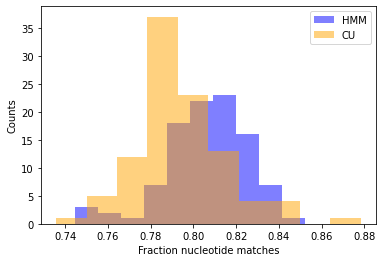

In [28]:
plt.hist(hmm_fms, 10, facecolor='blue', alpha=0.5, label='HMM')
plt.hist(cu_fms, 10, facecolor='orange', alpha=0.5, label='CU')
plt.legend()
plt.xlabel('Fraction nucleotide matches')
plt.ylabel('Counts');

In [29]:
_, pval = ttest_rel(hmm_fms, cu_fms, alternative = "greater")
pval

6.656586080520897e-07

The HMM is outperforming the codon usage approach by a statistically significant margin.